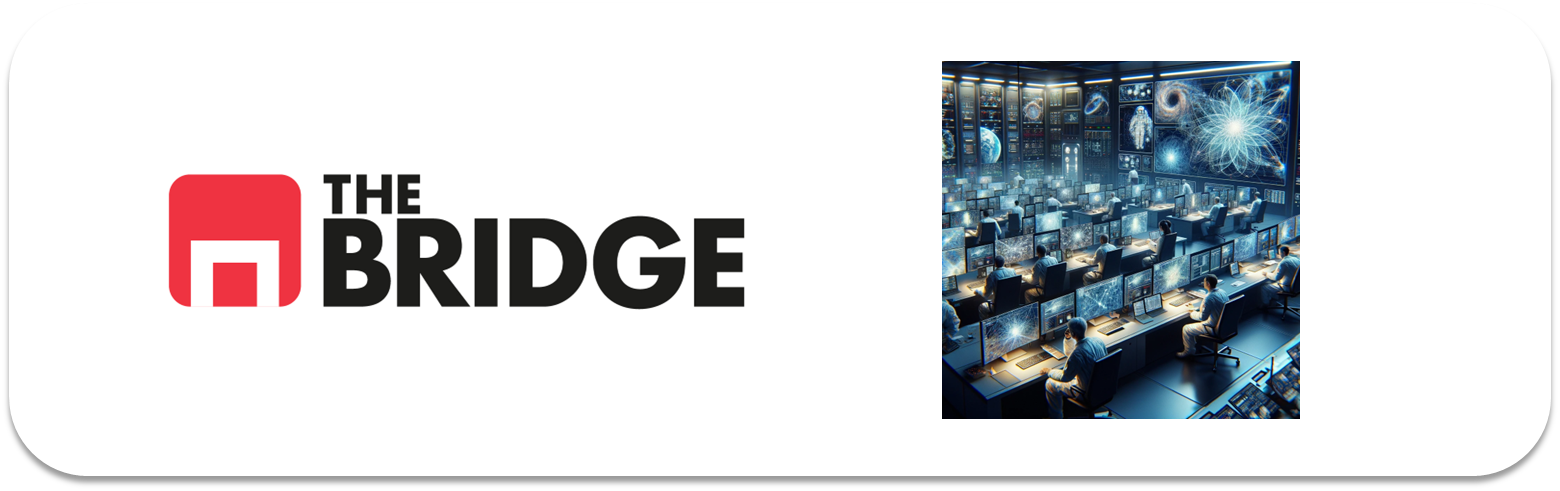

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
!pip install scikit-image

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras
import cv2

### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def load_images_from_folders(folder_list, img_size=(32, 32)):
    X = []
    y = []
    for folder in folder_list:
        folder_path = os.path.join("data", folder)
        for filename in os.listdir(folder_path):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                label = 1 if 'dog' in filename.lower() else 0
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    X.append(img)
                    y.append(label)
    return np.array(X), np.array(y)

# Carpetas de entrenamiento
train_folders = ['github_train_0', 'github_train_1', 'github_train_2', 'github_train_3']
X_train, y_train = load_images_from_folders(train_folders)

# Carpeta de test
test_folders = ['github_test']
X_test, y_test = load_images_from_folders(test_folders)

# Normalizamos los valores de píxeles [0, 255] → [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(f"Train: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test: {X_test.shape}, Labels: {y_test.shape}")


Train: (4000, 32, 32, 3), Labels: (4000,)
Test: (1000, 32, 32, 3), Labels: (1000,)


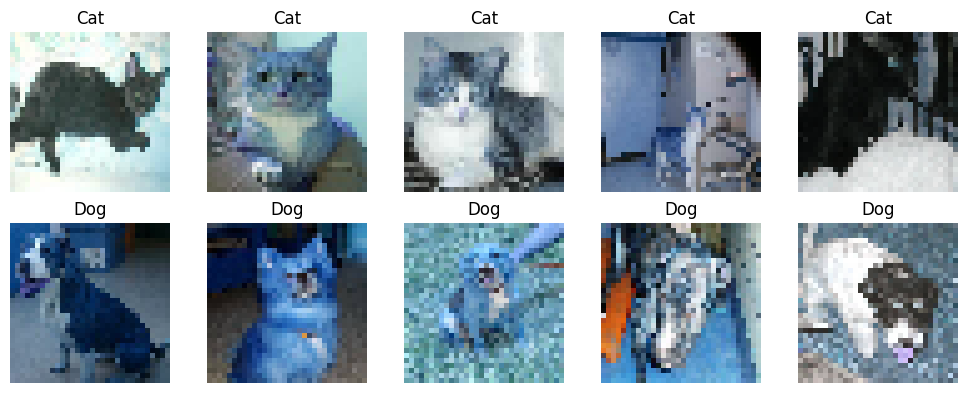

In [4]:
import matplotlib.pyplot as plt

def plot_sample_images(X, y, class_names=['Cat', 'Dog'], samples_per_class=5):
    plt.figure(figsize=(samples_per_class * 2, 4))

    for label in range(2):  # 0: Cat, 1: Dog
        class_indices = np.where(y == label)[0]
        selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)
        for i, idx in enumerate(selected_indices):
            plt.subplot(2, samples_per_class, label * samples_per_class + i + 1)
            plt.imshow(X[idx])
            plt.title(class_names[label])
            plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(X_train, y_train)


Distribución en entrenamiento:
label_name
Cat    2000
Dog    2000
Name: count, dtype: int64


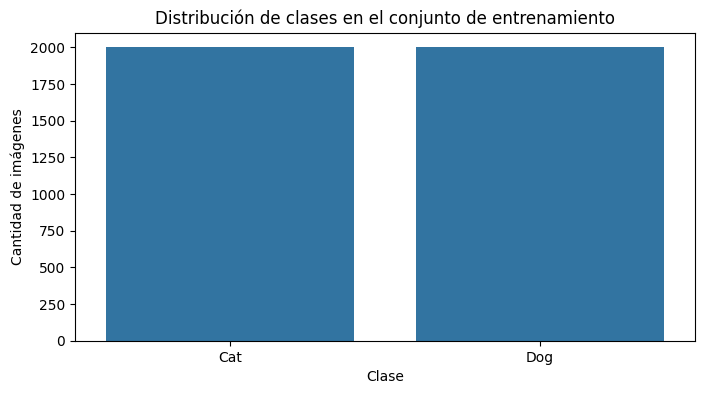

In [5]:

# Crear DataFrame temporal para conteo
train_df = pd.DataFrame({'label': y_train})
test_df = pd.DataFrame({'label': y_test})

# Reemplazar 0/1 por nombres de clase
train_df['label_name'] = train_df['label'].map({0: 'Cat', 1: 'Dog'})

# Mostrar conteos
print("Distribución en entrenamiento:")
print(train_df['label_name'].value_counts())


# Gráfico
plt.figure(figsize=(8, 4))
sns.countplot(data=train_df, x='label_name')
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xlabel("Clase")
plt.ylabel("Cantidad de imágenes")
plt.show()

In [55]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


capas = [keras.layers.Conv2D(filters = 50, kernel_size = (3, 3),
                            input_shape = (X_train[0].shape), 
                            padding = "same",
                            activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos otra capa de convolución y pooling
         keras.layers.Conv2D(filters = 25, 
                             kernel_size = (3, 3),
                             padding = "same", 
                             activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos una capa de flatten para convertir la salida de la capa de pooling en un vector
         keras.layers.Flatten(),

# Añadimos dos capas densas para la clasificación 
         keras.layers.Dense(units = 150, activation = 'relu'),
         keras.layers.Dense(units = 100, activation = 'relu'),

# Añadimos la capa de salida con 6 neuronas, una por cada clase
         keras.layers.Dense(1, activation = 'sigmoid')]

# Creamos el modelo
model = keras.Sequential(capas)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/Users/sensi/tf_pandas_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 50)     │         1,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 25)     │        11,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 25)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 150)            │       240,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,026 (1.02 MB)

 Trainable params: 268,026 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
targets = pd.Series(y_train)
targets.value_counts(True)

0    0.5
1    0.5
Name: proportion, dtype: float64

In [57]:
X_train, y_train = shuffle(X_train, y_train)

In [58]:
history = model.fit(X_train,
                    y_train,
                    validation_split = 0.2,
                    epochs = 200,
                    batch_size = 32, callbacks= [keras.callbacks.EarlyStopping(patience = 30, restore_best_weights= True)]) # Queremos recuperar los pesos de la mejor de las epocas durante el periodo de patience

Epoch 1/200


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5260 - loss: 0.6914 - val_accuracy: 0.6425 - val_loss: 0.6664
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6504 - loss: 0.6439 - val_accuracy: 0.5663 - val_loss: 0.6907
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6746 - loss: 0.6041 - val_accuracy: 0.6650 - val_loss: 0.6113
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7149 - loss: 0.5624 - val_accuracy: 0.6787 - val_loss: 0.6038
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7407 - loss: 0.5240 - val_accuracy: 0.7000 - val_loss: 0.5636
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7373 - loss: 0.5163 - val_accuracy: 0.6938 - val_loss: 0.5713
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7762 - loss: 0.4794 - val_accuracy: 0.7100 - val_loss: 0.5911
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8072 - loss: 0.4275 - val_accuracy

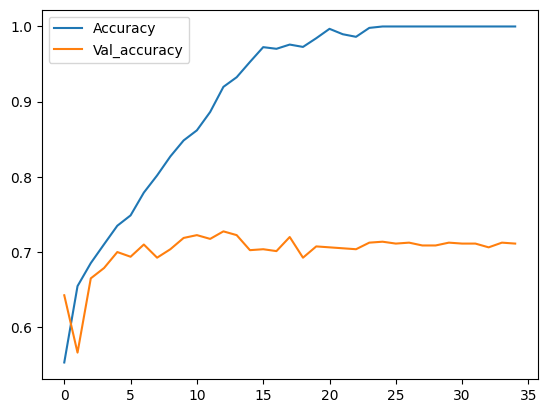

In [59]:
# Representamos el objeto history
history_df = pd.DataFrame(history.history)
plt.plot(history_df['accuracy'], label = 'Accuracy')
plt.plot(history_df['val_accuracy'], label = 'Val_accuracy')

plt.legend();

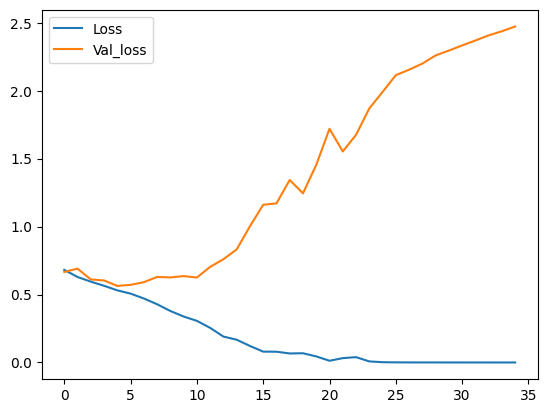

In [60]:
plt.plot(history_df['loss'], label = 'Loss')
plt.plot(history_df['val_loss'], label = 'Val_loss')

plt.legend();

In [61]:
#Evaluo el modelo
model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6891 - loss: 0.5690


[0.5703216195106506, 0.6909999847412109]

72% de Accuracy

In [62]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs >= 0.5).astype(int).flatten()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [63]:
mapa = {0: 'Cat', 1:'Dog'}

In [64]:
print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))

              precision    recall  f1-score   support

         Cat       0.68      0.73      0.70       500
         Dog       0.71      0.66      0.68       500

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000



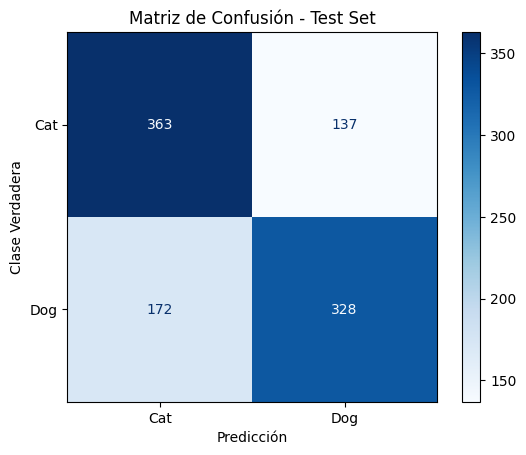

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcular la matriz
cm = confusion_matrix(y_test, y_pred)

# Mostrar
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])
disp.plot(cmap='Blues', values_format='d')  # valores enteros

plt.title("Matriz de Confusión - Test Set")
plt.xlabel("Predicción")
plt.ylabel("Clase Verdadera")
plt.show()

In [68]:
# Obtener las probabilidades predichas por el modelo
y_pred_probs = model.predict(X_test).flatten()

# Calcular las predicciones (0 o 1)
y_pred = (y_pred_probs >= 0.5).astype(int)

# Encontrar índices de errores
errores_idx = np.where(y_pred != y_test)[0]

# Filtrar errores por tipo
# - Perros mal clasificados como gatos (true = 1, pred = 0)
perros_mal = [idx for idx in errores_idx if y_test[idx] == 1 and y_pred[idx] == 0]

# Gatos mal clasificados como perros (true = 0, pred = 1)
gatos_mal = [idx for idx in errores_idx if y_test[idx] == 0 and y_pred[idx] == 1]

# Ordenar los errores por "confianza equivocada"
# (perros con prob alta de ser perro, gatos con prob baja de ser gato)
perros_ordenados = sorted(perros_mal, key=lambda i: y_pred_probs[i], reverse=True)
gatos_ordenados = sorted(gatos_mal, key=lambda i: y_pred_probs[i])  # prob baja

# Tomar el 10% de cada grupo
n_perros = max(1, int(len(perros_ordenados) * 0.1))
n_gatos = max(1, int(len(gatos_ordenados) * 0.1))

perros_dificiles_idx = perros_ordenados[:n_perros]
gatos_dificiles_idx = gatos_ordenados[:n_gatos]


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/var/folders/tb/bzmqvp956c176vyy0ydx7kl00000gn/T/ipykernel_25552/758885681.py:15: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


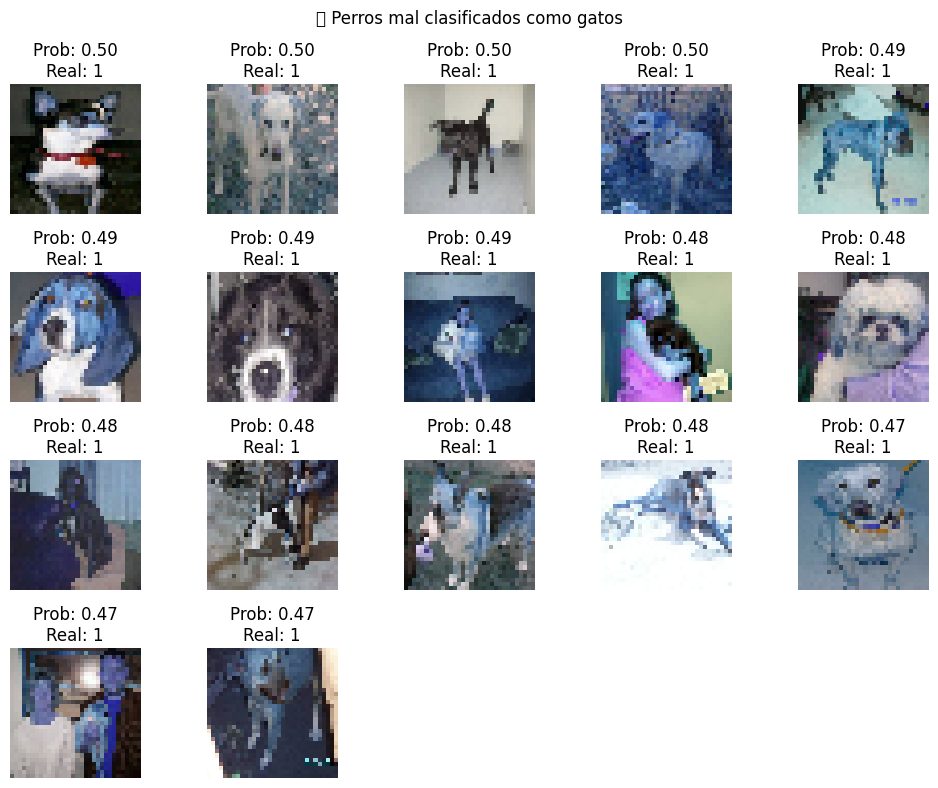

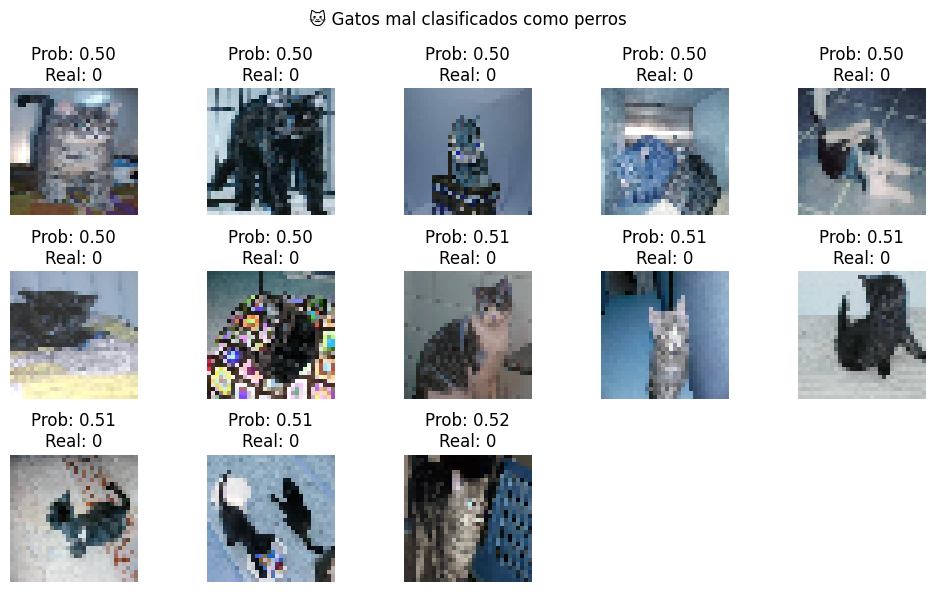

In [69]:
import matplotlib.pyplot as plt

def mostrar_imagenes(indices, titulo, X, y_true, y_prob, n_cols=5):
    n = len(indices)
    n_rows = (n + n_cols - 1) // n_cols
    plt.figure(figsize=(n_cols * 2, n_rows * 2))

    for i, idx in enumerate(indices):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(X[idx])
        plt.title(f"Prob: {y_prob[idx]:.2f}\nReal: {y_true[idx]}")
        plt.axis('off')

    plt.suptitle(titulo)
    plt.tight_layout()
    plt.show()

mostrar_imagenes(perros_dificiles_idx, "🐶 Perros mal clasificados como gatos", X_test, y_test, y_pred_probs)
mostrar_imagenes(gatos_dificiles_idx, "🐱 Gatos mal clasificados como perros", X_test, y_test, y_pred_probs)
